In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as snc

import netCDF4 as nc
# from netCDF4 import Dataset 
plt.style.use('classic')
import warnings

# added later
from sklearn.preprocessing import StandardScaler
from datasketch import MinHash, MinHashLSH
from scipy.spatial.distance import euclidean

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [2]:
modis_ds = nc.Dataset('/Volumes/Aqua-1/SST_OOD/MODIS_L2/PreProc/MODIS_R2019_2003_95clear_128x128_preproc_std.h5')
modis_ds_valid = modis_ds['valid'][:100000, 0, :, :]
modis_ds_valid.shape

(100000, 64, 64)

# Feature Extraction:

In [3]:
# Step 1: Flatten the 64x64 regions
flattened_features = modis_ds_valid.reshape(modis_ds_valid.shape[0], -1)  # Reshapes to (700000, 4096)
# Step 2: Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(flattened_features)

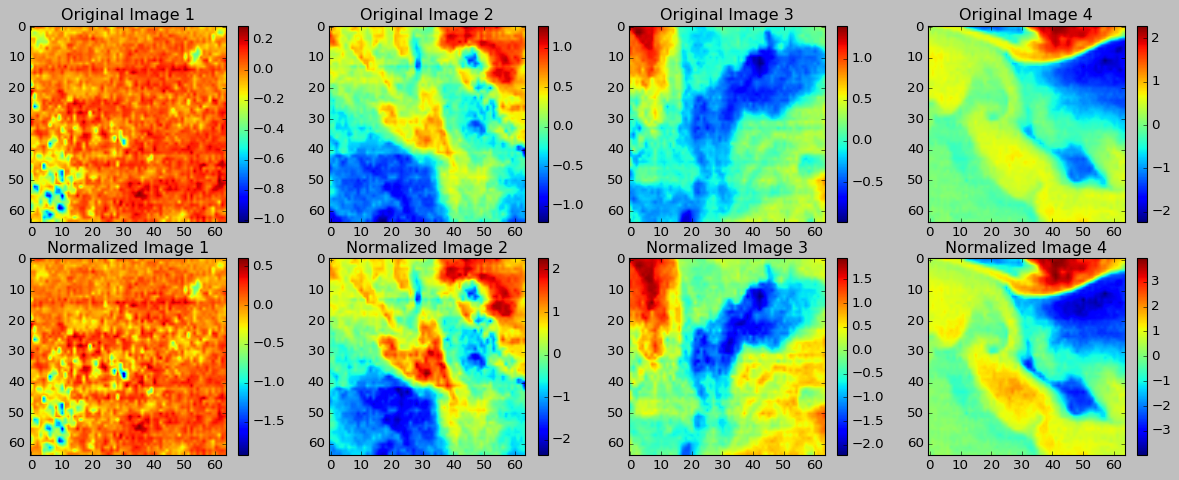

In [4]:
# Simulating a smaller version of the dataset for demonstration
np.random.seed(0)

# Selecting 4 random images from the dataset
np.random.seed(0)
indices = np.random.choice(modis_ds_valid.shape[0], 4, replace=False)
selected_images = modis_ds_valid[indices]

# Normalizing the data
scaler = StandardScaler()
normalized_features_mock = scaler.fit_transform(modis_ds_valid.reshape(-1, 64*64)).reshape(-1, 64, 64)
selected_normalized_images = normalized_features_mock[indices]

# Plotting the original and normalized images
fig, axes = plt.subplots(2, 4, figsize=(15, 6))

for i in range(4):
    # Original image
    im = axes[0, i].imshow(selected_images[i])
    axes[0, i].set_title(f"Original Image {i+1}")
    fig.colorbar(im, ax=axes[0, i])  # Add colorbar for each original image


    # Normalized image
    im_norm = axes[1, i].imshow(selected_normalized_images[i])
    axes[1, i].set_title(f"Normalized Image {i+1}")
    fig.colorbar(im_norm, ax=axes[1, i])  # Add colorbar for each normalized image


plt.tight_layout()
plt.show()



In [5]:
def preprocess_data(data):
    # Flatten the 64x64 region to a 1D vector (4096 elements)
    flattened_data = data.reshape(data.shape[0], -1)
    
    # Normalize the data
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(flattened_data)

    return normalized_data


In [6]:


def lsh_top_dissimilar(normalized_data, num_perm=512, num_top=100):
    # Initialize LSH
    lsh = MinHashLSH(threshold=0.5, num_perm=num_perm)
    
    # Create MinHash objects
    minhashes = {}
    for i, vec in enumerate(normalized_data):
        m = MinHash(num_perm=num_perm)
        for d in vec:
            m.update(str(d).encode('utf8'))
        minhashes[i] = m
        lsh.insert(i, m)
    
    # Calculate pairwise distances and find top dissimilar
    dissimilarity = []
    for i in range(len(normalized_data)):
        distances = []
        for j in range(len(normalized_data)):
            if i != j:
                distance = minhashes[i].jaccard(minhashes[j])
                distances.append((j, distance))
        distances.sort(key=lambda x: x[1], reverse=True)  # Sort by distance, descending
        top_dissimilar = distances[:num_top]
        dissimilarity.append((i, top_dissimilar))

    return dissimilarity


In [7]:
normalized_data = preprocess_data(modis_ds_valid)
dissimilar_images = lsh_top_dissimilar(normalized_data)

# Now, 'dissimilar_images' contains tuples of (image_index, [(dissimilar_image_index, distance), ...])

In [8]:
dissimilar_images[0][1][:15], dissimilar_images[1][1][:15]

([(1435, 0.005859375),
  (2319, 0.005859375),
  (66218, 0.005859375),
  (99160, 0.005859375),
  (4256, 0.00390625),
  (5076, 0.00390625),
  (9131, 0.00390625),
  (9759, 0.00390625),
  (9790, 0.00390625),
  (11629, 0.00390625),
  (15083, 0.00390625),
  (17805, 0.00390625),
  (19838, 0.00390625),
  (20842, 0.00390625),
  (20959, 0.00390625)],
 [(50285, 0.005859375),
  (68132, 0.005859375),
  (482, 0.00390625),
  (7201, 0.00390625),
  (9750, 0.00390625),
  (11724, 0.00390625),
  (14818, 0.00390625),
  (15456, 0.00390625),
  (16196, 0.00390625),
  (21098, 0.00390625),
  (23640, 0.00390625),
  (23903, 0.00390625),
  (32204, 0.00390625),
  (32756, 0.00390625),
  (38846, 0.00390625)])

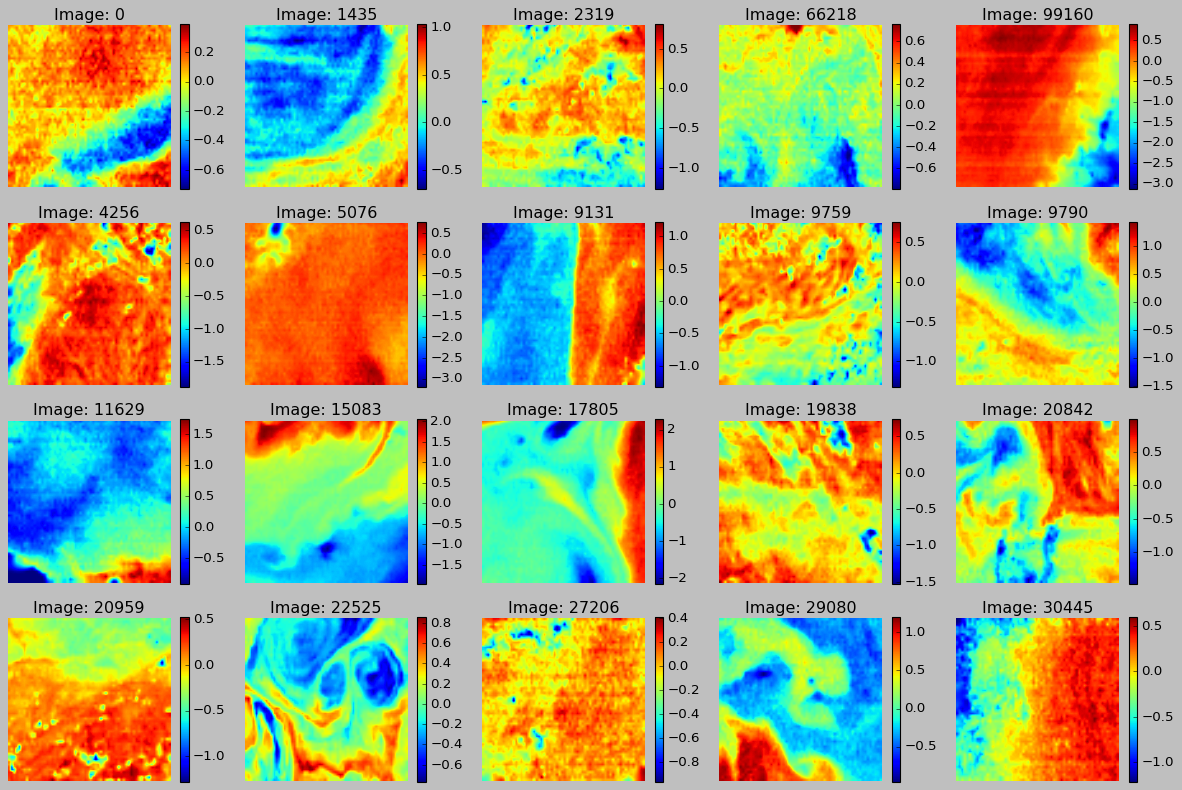

In [17]:
def plot_dissimilar_images_grid(data, dissimilar_images, image_index, num_images=19, grid_cols=5):
    """
    Plots the original image and its dissimilar images in a grid with colorbars.
    :param data: The original dataset of images.
    :param dissimilar_images: A list of tuples containing dissimilar image indices.
    :param image_index: The index of the image to compare.
    :param num_images: Number of dissimilar images to plot (excluding the reference image).
    :param grid_cols: Number of columns in the grid.
    """
    # Get the indices of the dissimilar images for the specified image
    dissimilar_indices = [pair[0] for pair in dissimilar_images[image_index][1][:num_images]]

    # Total images including the reference image
    total_images = 1 + num_images

    # Calculate number of rows needed for the grid
    grid_rows = total_images // grid_cols + (total_images % grid_cols > 0)

    # Setting up the plot dimensions
    plt.figure(figsize=(15, 3 * 3.33))

    # Plotting the original image
    plt.subplot(grid_rows, grid_cols, 1)
    im = plt.imshow(data[image_index])
    plt.title(f'Image: {image_index}')
    plt.axis('off')
    plt.colorbar(im)

    # Plotting the dissimilar images in the grid
    for i, idx in enumerate(dissimilar_indices):
        plt.subplot(grid_rows, grid_cols, i + 2)  # +2 to account for the original image
        im = plt.imshow(data[idx])
        plt.title(f'Image: {idx}')
        plt.axis('off')
        plt.colorbar(im, ax=plt.gca())

    plt.tight_layout()
    plt.show()

plot_dissimilar_images_grid(modis_ds_valid, dissimilar_images, image_index=0, num_images=19, grid_cols=5)


In [20]:


def calculate_histogram_intersection(image1, image2):
    hist1, _ = np.histogram(image1, bins=256, range=(0, 256))
    hist2, _ = np.histogram(image2, bins=256, range=(0, 256))
    return np.sum(np.minimum(hist1, hist2)) / np.sum(hist2)

def calculate_statistics(data, reference_idx, dissimilar_indices):
    stats = {}
    ref_image = data[reference_idx]

    # Statistics for the reference image
    stats[reference_idx] = {
        'min_temp': np.min(ref_image),
        'max_temp': np.max(ref_image),
        'avg_temp': np.mean(ref_image)
    }

    # Statistics for each dissimilar image
    for idx in dissimilar_indices:
        image = data[idx]
        stats[idx] = {
            'min_temp': np.min(image),
            'max_temp': np.max(image),
            'avg_temp': np.mean(image),
            'avg_corr': pearsonr(ref_image.flatten(), image.flatten())[0],
            'mse': mean_squared_error(ref_image, image),
            'hist_intersection': calculate_histogram_intersection(ref_image, image)
        }

    return stats

# Example usage
statistics = calculate_statistics(modis_ds_valid, 0, [pair[0] for pair in dissimilar_images[0][1][:19]])
